In [6]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [7]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [8]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

In [9]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

print('video length, ', _video_length)

video length,  7761


In [10]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

chessb_corners = []
counter = 0

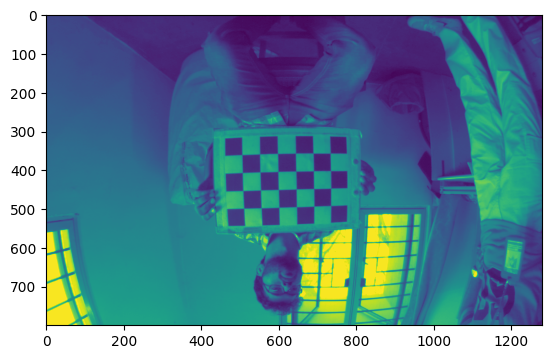

In [11]:
plt.imshow(_frame)

In [12]:
# for idx, frame in enumerate(tqdm(_video_data)):
def detectCorners(_frame):
    _frame = cv2.rotate(_frame.copy(), cv2.ROTATE_180)

    ret, corners = cv2.findChessboardCorners(_frame, patternSize)
    if ret:
        corners = cv2.cornerSubPix(
            _frame,
            corners,
            (5, 5),
            (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001),
        )
    return corners
# Parallel execution with joblib
chessb_corners = []
results = Parallel(n_jobs=20, verbose=0)(
    delayed(detectCorners)(frame) for frame in tqdm(_video_data)
)
# Collect results
for result in results:
    if result is not None:
        chessb_corners.append(result)

0it [00:00, ?it/s]

In [13]:
# chessb_corners[0]

In [14]:
# Get the directory of the video file
video_dir = os.path.dirname(_video_pth)
corners_file = os.path.join(video_dir, "chessb_corners.msgpack")

with open(corners_file, "wb") as f:
    _packed_file = mp.packb(chessb_corners, default=mpn.encode)
    f.write(_packed_file)

# del(chessb_corners)

In [15]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

In [1]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
# np.random.seed(9)

In [2]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_corners_pth = os.path.join(_webcam_calib_folder, "chessb_corners.msgpack")

In [3]:
# load data

_corners_file = open(_webcam_corners_pth, "rb")
chessb_corners = list(mp.Unpacker(_corners_file, object_hook=mpn.decode))
chessb_corners = chessb_corners[0]
chessb_corners = np.array(chessb_corners)

In [4]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [5]:

def calibrate_single_iteration(_):
    rnd = np.random.choice(len(chessb_corners), 80)
    chessb_c = chessb_corners[rnd]
    worldPoints = []
    imagePoints = []

    for _f in chessb_c:
        imagePoints.append(_f)
        worldPoints.append(boardPoints)

    if useFisheye:
        flagsCalib = (
            cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
            + cv2.fisheye.CALIB_FIX_SKEW
            + cv2.fisheye.CALIB_CHECK_COND
        )
        calibrateCriteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30,
            1e-12,
        )
        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
            np.expand_dims(np.asarray(worldPoints), -2),
            imagePoints,
            imgSize,
            None,
            None,
            flags=flagsCalib,
            criteria=calibrateCriteria,
        )
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL
        ret, cameraMatrix, k, R, t = cv2.calibrateCamera(
            worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
        )

    # print(worldPoints)
    return {"ReError": ret, "mat": cameraMatrix, "dist": k, "rvec": R, "tvec": t, 'rnd':rnd}


# Parallel execution with joblib
my_dict = {"ReError": [], "mat": [], "dist": [], "rvec": [], "tvec": [], 'rnd_value':[]}

results = Parallel(n_jobs=20, verbose=0)(
    delayed(calibrate_single_iteration)(_) for _ in tqdm(range(100))
)
# Collect results
for result in results:
    my_dict["ReError"].append(result["ReError"])
    my_dict["mat"].append(result["mat"])
    my_dict["dist"].append(result["dist"])
    my_dict["rvec"].append(result["rvec"])
    my_dict["tvec"].append(result["tvec"])
    my_dict['rnd_value'].append(result['rnd'])


# calibrate_single_iteration(10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# video_dir = os.path.dirname(_video_pth)
calibration_file = os.path.join(_webcam_calib_folder, "calibration_data_100values.msgpack")

with open(calibration_file, "wb") as f:
    _packed_file = mp.packb(my_dict, default=mpn.encode)
    f.write(_packed_file)

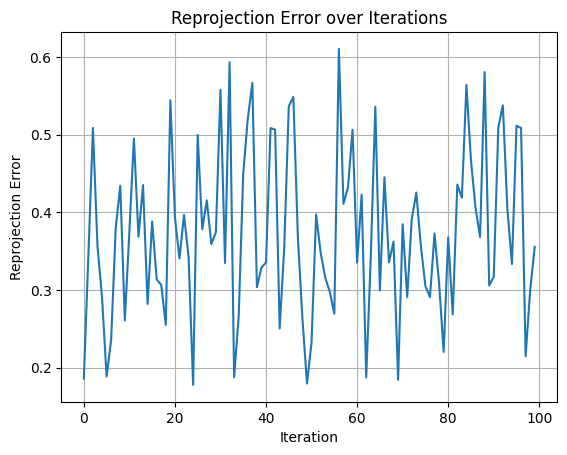

In [7]:
plt.plot(my_dict['ReError'])
plt.xlabel('Iteration')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error over Iterations')
plt.grid()

In [8]:
min_rerr_idx = np.argmin(my_dict['ReError'])
print('Minimum Reprojection Error:', my_dict['ReError'][min_rerr_idx], ' at index ', min_rerr_idx)

Minimum Reprojection Error: 0.17770594861207736  at index  24


In [9]:
rerr = my_dict['ReError'][min_rerr_idx]
camera_mat = my_dict['mat'][min_rerr_idx]
camera_dist = my_dict['dist'][min_rerr_idx]

In [10]:
print(rerr, camera_mat, camera_dist)

0.17770594861207736 [[582.82008552   0.         654.37068466]
 [  0.         587.10762439 336.54060703]
 [  0.           0.           1.        ]] [[-0.03279618]
 [-0.00176171]
 [-0.00349704]
 [ 0.00065695]]


Translation Vector Standard Deviation: [192.96685039 107.02510352  77.33976359]


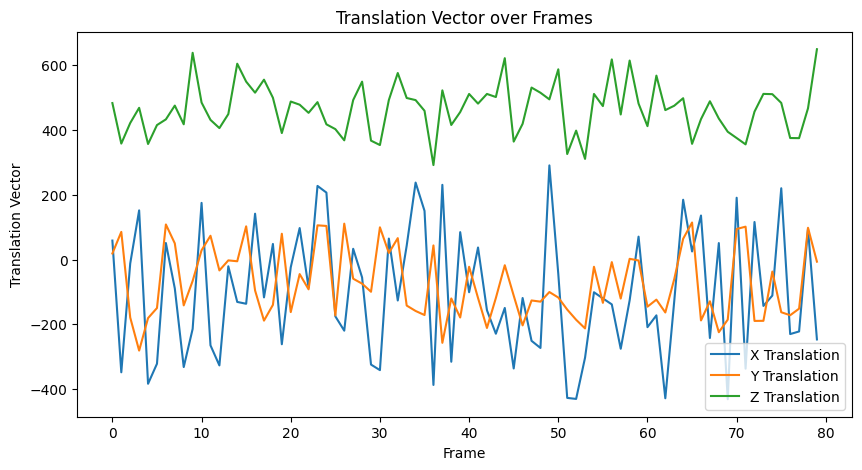

In [11]:
# plot the translation vector
tvec = my_dict['tvec'][0]
tvec = np.array(tvec).T[0]
plt.figure(figsize=(10, 5))
plt.plot(tvec[0], label='X Translation')
plt.plot(tvec[1], label='Y Translation')
plt.plot(tvec[2], label='Z Translation')
plt.xlabel('Frame')
plt.ylabel('Translation Vector')
plt.title('Translation Vector over Frames')
plt.legend()

# standard deviation of the translation vector
tvec_std = np.std(tvec, axis=1)
print('Translation Vector Standard Deviation:', tvec_std)

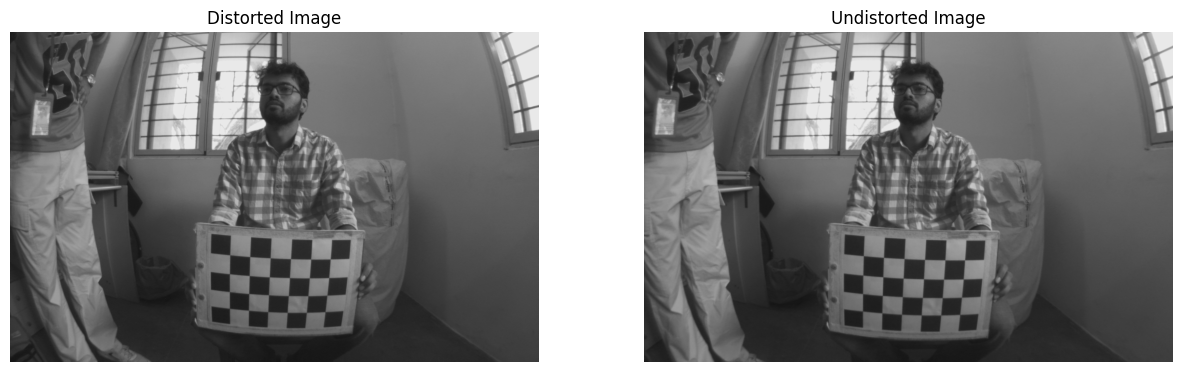

In [12]:
# show distorted and undistorted images
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
for idx, frame in enumerate(_video_data):
    # frame = cv2.flip(frame, 0)
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame_undistorted = cv2.undistort(frame, camera_mat, camera_dist)
    # create a subplot with 2 images and break at first image and plot chessboard corners
    
    if idx == 0:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Distorted Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(frame_undistorted, cv2.COLOR_BGR2RGB))
        plt.title('Undistorted Image')
        plt.axis('off')
        plt.show()
        break

In [13]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

# Analysis by using a second video

In [2]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [22]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"
_recording_folder_name = "randomxyz_t0"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_reference_recording_folder = os.path.join(
    _pth, '..', _parent_folder, "recordings",'160_fov','3marker_complete_data', _recording_folder_name
)
_reference_file = os.path.join(_reference_recording_folder, "webcam_color.msgpack")

# for loading 9000 values
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_1000.msgpack')

# for loading just 100 points
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_100values.msgpack')




In [15]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [16]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [23]:
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [27]:
_calib_data[1]

IndexError: list index out of range

In [28]:
len(_calib_data[0]['ReError'])

100

In [29]:
# selecting random 50 frames
np.random.seed(9)
_random_reference_frames_idx = np.random.choice(_ref_video_length, 300)

_ref_data = mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode)

# _ref_frames = []

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[]}

for idx, _frame in tqdm(enumerate(_ref_data)):
    if idx in _random_reference_frames_idx:

        # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
        _frame = cv2.flip(_frame, 1)
        res = detector.detectMarkers(_frame,)
        
        res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
        ar_results['corners'].append(res[0])
        ar_results['ids'].append(res[1])
        ar_results['rejected'].append(res[2])

    # if idx in _random_reference_frames_idx:
    #     _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    #     _ref_frames.append(_frame)


0it [00:00, ?it/s]

In [30]:
# _frame = cv2.flip(_frame, 0)
# _frame = cv2.flip(_frame, 0)
# plt.imshow(_ref_frames[0])

In [31]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import cv2
from joblib import Parallel, delayed

# Define filtering functions outside the loop
def filter_90th_percentile_zscore(data, z_threshold=1.28):  # z=1.28 corresponds to ~90th percentile
    """Filter data to keep only values within 90th percentile using z-score"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    z_scores = np.abs(stats.zscore(data_clean))
    return data_clean[z_scores <= z_threshold]

def filter_90th_percentile_direct(data):
    """Filter data to keep only values up to 90th percentile"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    percentile_90 = np.percentile(data_clean, 90)
    return data_clean[data_clean <= percentile_90]

def process_single_calibration(idx, cal, ar_results):
    """Process a single calibration matrix"""
    mat = cal[0]
    dist = cal[1]
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        mat, dist, np.eye(3), mat, (1200, 800), cv2.CV_16SC2
    )
    new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
        mat, dist, (1200, 800), None, None, cv2.CALIB_USE_INTRINSIC_GUESS
    )
    
    ordered_results = {'20': {'tvecs': [], 'rvecs': []},
                       '12': {'tvecs': [], 'rvecs': []},
                       '14': {'tvecs': [], 'rvecs': []}}
   
    vector_length = {'v1':[], 'v2':[], 'v3':[]}
    
    for res in zip(ar_results['ids'], ar_results['corners']):
        undistorted_corners = []
        for marker_corner in res[1]:
            undistorted_corners.append(cv2.undistortPoints(marker_corner.reshape(-1, 1, 2), mat, dist))
        undistorted_corners = np.array(undistorted_corners)
        pose = estimate_pose_single_markers(res[1], 0.05, mat, dist)
        v_12, v_14, v_20 = np.zeros((1,3)), np.zeros((1,3)), np.zeros((1,3))
        
        for idx_marker, id in enumerate(res[0].reshape(-1)):
            match id:
                case 20:
                    ordered_results['20']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['20']['rvecs'].append(pose[0][idx_marker])
                    v_20 = pose[1][idx_marker]
                case 12:
                    ordered_results['12']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['12']['rvecs'].append(pose[0][idx_marker])
                    v_12 = pose[1][idx_marker]
                case 14:
                    ordered_results['14']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['14']['rvecs'].append(pose[0][idx_marker])
                    v_14 = pose[1][idx_marker]
                case _:
                    continue
       
        # Calculate vector lengths
        vector_length['v1'].append(np.linalg.norm(v_12 - v_14))
        vector_length['v2'].append(np.linalg.norm(v_14 - v_20))
        vector_length['v3'].append(np.linalg.norm(v_20 - v_12))
   
    # Apply filtering to each vector length array
    v1_filtered = filter_90th_percentile_direct(vector_length['v1'])
    v2_filtered = filter_90th_percentile_direct(vector_length['v2'])
    v3_filtered = filter_90th_percentile_direct(vector_length['v3'])
    
    # Calculate standard deviation on filtered data
    v1_std_val = np.nanstd(v1_filtered) if len(v1_filtered) > 0 else np.nan
    v2_std_val = np.nanstd(v2_filtered) if len(v2_filtered) > 0 else np.nan
    v3_std_val = np.nanstd(v3_filtered) if len(v3_filtered) > 0 else np.nan
    
    # Sum of standard deviations
    v1_std_final = v1_std_val if not np.isnan(v1_std_val) else 0
    v2_std_final = v2_std_val if not np.isnan(v2_std_val) else 0
    v3_std_final = v3_std_val if not np.isnan(v3_std_val) else 0
    sum_std = v1_std_final + v2_std_final + v3_std_final
    
    return {
        'calib_idx': idx,
        'ar_data': ordered_results,
        'v1std': v1_std_val,
        'v2std': v2_std_val,
        'v3std': v3_std_val,
        'sum': sum_std
    }

# Parallel processing of calibration matrices
print("Processing calibration matrices in parallel...")
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

# Use joblib to parallelize calibration processing
# n_jobs=-1 uses all available cores, you can set specific number like n_jobs=4
results = Parallel(n_jobs=20, verbose=1)(
    delayed(process_single_calibration)(idx, cal, ar_results) 
    for idx, cal in enumerate(tqdm(calibration_data, desc="Preparing calibration jobs"))
)

# Collect results
for result in results:
    ar_total_results['calib_idx'].append(result['calib_idx'])
    ar_total_results['ar_data'].append(result['ar_data'])
    vector_std['v1std'].append(result['v1std'])
    vector_std['v2std'].append(result['v2std'])
    vector_std['v3std'].append(result['v3std'])
    vector_std['sum'].append(result['sum'])

Processing calibration matrices in parallel...


Preparing calibration jobs: 100%|██████████| 100/100 [00:04<00:00, 21.52it/s]
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    5.7s finished


In [32]:
_optimization_file = os.path.join(_webcam_calib_folder, "optimization_file.msgpack")

with open(_optimization_file, "wb") as f:
    _packed_file = mp.packb([ar_total_results, vector_std], default=mpn.encode)
    f.write(_packed_file)

In [ ]:
np.argmin(vector_s
          td['sum']), vector_std['sum'][np.argmin(vector_std['sum'])]

(np.int64(10), np.float64(0.0038651103998989123))

In [34]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined